In [ ]:
"""
Financial News RAG Model

This project implements a Retrieval-Augmented Generation (RAG) model with LangChain and Mistral to answer financial questions based on the latest news. It combines retrieval and generation for providing accurate, source-referenced responses. The architecture is a chain-style graph with memory for context-based QA.

Key Components:
- Vector Store: Stores news article embeddings for semantic search.
- Retriever: Retrieves the most relevant news for a given query when necessary.
- LLM with Tools: Generates responses using both retrieval results and language modeling.
- State Graph: Implements a conditioned reasoning chain.

Usage:
- Run the project with `ask_chain()` to query the model:
    ask_chain(graph, "What is the latest update on Apple stock prices?")
- Responses will include answers with source references.

Example Query:
    User: "What is the latest update on Apple stock prices?"
    Assistant: 
        Answer: Analysts predict Apple’s stock may rise due to strong quarterly earnings.  
        Sources: Bloomberg (Published: 2025-02-10), CNBC (Published: 2025-02-11)

Dependencies:
- Python 3.11
- LangChain
- Pinecone

Author:
    Yeva Velychko
Version: 
    1.0  
Date:
    February 15, 2025
"""

In [ ]:
!pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph
!pip install -U langchain-ollama
# !ollama pull llama3
!ollama pull mistral

In [ ]:
import os
from dotenv import load_dotenv
from langchain_ollama import ChatOllama, OllamaEmbeddings

In [1]:
load_dotenv()

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")

In [250]:
llm = ChatOllama(
    model = "mistral",
    temperature = 0.4,  # low temperature for more fact-based responses
    num_predict = 256,
)

embed = OllamaEmbeddings(
    model="mistral"
)

In [4]:
# testing the embed model
test_text = "Hello, this is a test for embeddings."

try:
    embedding_vector = embed.embed_query(test_text)
    embedding_length = len(embedding_vector)
    print(f"Vector size: {embedding_length}")  
    print(f"First 5 values: {embedding_vector[:5]}")
except Exception as e:
    print(f"Error generating embeddings: {e}")

Vector size: 4096
First 5 values: [0.016489906, -0.029164085, -0.0030536354, 0.0061009917, -0.008788722]


## Preparing the News

In [ ]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from datetime import datetime
import requests
from bs4 import BeautifulSoup, SoupStrainer
import re
from langchain.document_loaders import WebBaseLoader
from langchain.schema import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [122]:
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
pc = Pinecone(api_key=PINECONE_API_KEY)

index_name = "finance-news-mistral"
try:
    pc.Index(index_name)
except Exception as e:
    pc.create_index(index_name,
                                  spec=ServerlessSpec(
                                      cloud="aws",
                                      region="us-east-1"
                                  ),
                                  dimension=embedding_length, # embedding size of the embedding model
                                  metric="cosine")
    
index = pc.Index(index_name)
vector_store = PineconeVectorStore(embedding=embed, index=index)

In [107]:
def fetch_stock_news(tickers: list[str], limit: int = 15) -> list[dict]:
    """
    Fetch the latest stock news articles from Alpha Vantage API.

    Args:
        tickers (list[str]): List of stock tickers (e.g., ['AAPL', 'MSFT']).
        limit (int, optional): Maximum number of news articles to fetch. Defaults to 15.

    Returns:
        list[dict]: A list of dictionaries containing news titles, URLs, and publication times.
    """
    api_key = os.getenv("ALPHAVANTAGE_API_KEY")
    if not api_key:
        raise ValueError("API key is missing. Set ALPHAVANTAGE_API_KEY environment variable.")
    
    # constructing the API URL
    base_url = "https://www.alphavantage.co/query?function=NEWS_SENTIMENT"
    tickers_param = f"&tickers={','.join(tickers)}" if tickers else ""
    url = f"{base_url}{tickers_param}&apikey={api_key}"
    
    # sending the request
    response = requests.get(url)
    data = response.json()
    
    # checking if the response contains news
    if "feed" in data:
        print(data["feed"][0])
        news_articles = [
            {"title": article["title"], 
             "url": article["url"], 
             "time_published": datetime.strptime(article["time_published"], "%Y%m%dT%H%M%S").strftime("%d %B %Y, %H:%M:%S"),  # converting to readable format
             # "summary": article["summary"]
             }
            for article in data["feed"][:limit]
        ]
        return news_articles
    else:
        print("Error fetching news:", data)
        return []

news = fetch_stock_news(["AAPL", 
                         # "CRYPTO:BTC"
                         ], limit=30)
print(news)

{'title': 'TikTok Returns To Apple And Google App Stores After A Month-Long Hiatus - Alphabet  ( NASDAQ:GOOG ) , Apple  ( NASDAQ:AAPL ) ', 'url': 'https://www.benzinga.com/markets/25/02/43724471/tiktok-returns-to-apple-and-google-app-stores-after-a-month-long-hiatus', 'time_published': '20250214T110732', 'authors': ['Namrata Sen'], 'summary': 'TikTok, the Chinese short video platform, has reappeared on the Apple and Google app stores following a month-long hiatus. What Happened: TikTok officially announced that the app was restored to the app stores of Apple Inc. AAPL and Alphabet Inc. GOOGL GOOG on Thursday evening.', 'banner_image': 'https://cdn.benzinga.com/files/images/story/2025/02/14/TikTok-Installed-iPhones-Are-Being-Liste.jpeg?width=1200&height=800&fit=crop', 'source': 'Benzinga', 'category_within_source': 'Markets', 'source_domain': 'www.benzinga.com', 'topics': [{'topic': 'Technology', 'relevance_score': '0.5'}, {'topic': 'Manufacturing', 'relevance_score': '0.5'}], 'overall_

In [113]:
def clean_text(text: str) -> str:
    """
    Cleans the text by removing URLs and unwanted characters, keeping basic punctuation.

    Args:
        text (str): Raw text extracted from a webpage.

    Returns:
        str: Cleaned text with URLs and unnecessary symbols removed.
    """
    
    # removing URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    
    # removing all non-alphanumeric characters except spaces and punctuation marks (.,!?)
    text = re.sub(r'[^\w\s.,!?]', ' ', text).strip()

    return text

def extract_all_text(url: str) -> str:
    """
    Extracts the main textual content from a given webpage URL.
    
     Args:
        url (str): The URL of the webpage to extract text from.

    Returns:
        str: The extracted text as a string or an empty string if nothing was found.
    """
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0 Safari/537.36"
}
    try:
        # fetching the webpage content
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Failed loading {url}: {e}")
        return ""
    
    # parsing HTML content
    soup = BeautifulSoup(response.text, "html.parser")
    # print(soup.prettify())

    # looking for an article tag
    article = soup.find("article")
    if article:
        return "\n".join([p.get_text(strip=True) for p in article.find_all("p") if p.get_text(strip=True)])

    # parsing <p> tags in body contents if no article was found
    body = soup.body
    if body:
        return "\n".join([p.get_text(strip=True) for p in body.find_all("p") if p.get_text(strip=True)])

    return ""  # returning an empty string if no content is found


In [130]:
def load_news_content(news_articles: list[dict]) -> list[Document]:
    """
    Loads and processes news articles from URLs using LangChain WebBaseLoader 
    and applies all <body> text extraction if content is missing.

    Args:
        news_articles (list[dict]): A list of dictionaries with article information.
            Each dictionary should contain:
                - "url" (str): Article URL
                - "title" (str, optional): Article title
                - "time_published" (str, optional): Publication time

    Returns:
        list[Document]: A list of LangChain Document objects containing cleaned 
        article content and metadata.
    """
    loader = WebBaseLoader([article["url"] for article in news_articles],
                        show_progress=True,
                        bs_kwargs=dict(           
        parse_only=SoupStrainer(
            class_=("article-content-body", "article-content", "article-body", "post-content", "entry-content",
    "news-content", "story-body", "content-text", "main-content")
        )),
                           )
    docs = loader.load()
    # 
    # print(docs[0].page_content)
    # print(docs[0].metadata)
    
    for i, doc in enumerate(docs):
        if not doc.page_content.strip():  # if empty or whitespace-only 
            print(f"No article content found for {news_articles[i]['url']}, extracting the whole <body> contents.")
            # fallback to full <body> extraction
            doc.page_content = extract_all_text(doc.metadata["source"])
            # print("Extracted text: ", doc.page_content)
    
    # forming a list of Documents
    docs_with_metadata = []
    for doc, article in zip(docs, news_articles):
        doc_with_metadata = Document(
            # cleaning text and attaching metadata
            page_content=clean_text(doc.page_content),  
            metadata={
                "source": article["url"],
                "title": article.get("title", ""),
                "time_published": article.get("time_published", ""),
                # "summary": article.get("summary", "")
            }
        )
        # print(doc_with_metadata.page_content)
        docs_with_metadata.append(doc_with_metadata)
    
    return docs_with_metadata

# loading contents from fetched news
docs = load_news_content(news)

# print("Length of the first parsed doc: ", len(docs[0].page_content)) 
# print("Article example: ", docs[0].page_content)

No article content found for https://www.benzinga.com/markets/25/02/43724471/tiktok-returns-to-apple-and-google-app-stores-after-a-month-long-hiatus, extracting the whole <body> contents.
No article content found for https://www.zacks.com/stock/news/2415895/zacks-investment-ideas-feature-highlights-alibaba-jdcom-baidu-kweb-and-apple, extracting the whole <body> contents.
No article content found for https://www.benzinga.com/25/02/43721460/google-under-fire-as-mexico-considers-lawsuit-over-gulf-of-mexico-name-change, extracting the whole <body> contents.
No article content found for https://www.benzinga.com/markets/equities/25/02/43721445/apple-tesla-and-other-mag-7-peers-too-expensive-top-hedge-fund-challenges-overvaluation-concerns, extracting the whole <body> contents.
No article content found for https://www.benzinga.com/tech/25/02/43720367/tim-cook-confirms-new-apple-product-launch-next-week-elon-musk-sets-off-buzz-by-sharing-is-it-the-iphone-se-, extracting the whole <body> conten

In [ ]:
# url = "https://www.benzinga.com/25/02/43631776/apple-teams-up-with-alibaba-for-ai-innovation-in-china-submits-ai-features-for-regulatory-approval"  
# response = requests.get(url)
# soup = BeautifulSoup(response.text, "html.parser")
# 
# # taking a look at all classes of tags on a web page 
# for tag in soup.find_all(True):  
#     if tag.has_attr("class"):
#         print(tag.name, tag["class"])  

In [131]:
# splitting the news texts
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # chunk size (characters)
    chunk_overlap=50,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split {len(docs)} blog posts into {len(all_splits)} sub-documents.")

Split 30 blog posts into 209 sub-documents.


In [132]:
print(all_splits[0])

page_content='TikTok, the Chinese short video platform, has reappeared on theAppleandGoogleapp stores following a month long hiatus.
What Happened  TikTok officially announced that the app was restored to the app stores ofApple Inc.AAPLandAlphabet Inc.GOOGLGOOGon Thursday evening. The app was taken down on Jan 18, in response to TikTok s decision to temporarily halt its services in the U.S. due to a new national security law.' metadata={'source': 'https://www.benzinga.com/markets/25/02/43724471/tiktok-returns-to-apple-and-google-app-stores-after-a-month-long-hiatus', 'title': 'TikTok Returns To Apple And Google App Stores After A Month-Long Hiatus - Alphabet  ( NASDAQ:GOOG ) , Apple  ( NASDAQ:AAPL ) ', 'time_published': '14 February 2025, 11:07:32', 'start_index': 0}


In [134]:
# adding the documents to the vector store
for split in all_splits:
    print("Adding a split...")
    vector_store.add_documents([split])

Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a split...
Adding a s

## Retrieval and Generation

In [ ]:
from typing_extensions import Annotated
from typing_extensions import List, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState
from IPython.display import Image, display


In [ ]:
# from langchain import hub
# 
# prompt = hub.pull("rlm/rag-prompt")
# print(prompt)

In [194]:
class SearchResponse(TypedDict):
    """Structured response containing the answer and references."""
    answer: Annotated[str, ..., "Generated response to the search query."] = "No answer."
    sources: Annotated[List[str], ..., "List of sources used for the answer and their publication dates."] = []

In [ ]:
# from langchain_core.documents import Document
# 
# # defining the state
# class State(TypedDict):
#     question: str
#     query: Search
#     context: List[Document]
#     answer: str


In [ ]:
# # from langchain_core.tools import tool
# from langgraph.graph import START, StateGraph
# 
# def analyze_query(state: State):
#     # binding the output schema to the model
#     structured_llm = llm.with_structured_output(Search)
#     query = structured_llm.invoke(state["question"])
# 
#     print(f"Generated query: {query}") 
#     return {"query": query}
# 
# def retrieve(state: State):
#     query = state["query"]
#     # print(query)
#     pattern = re.compile(re.escape(query["source"]), re.IGNORECASE)  # building a regular expr to search for sources
#     # print(type(query["query"]))
#     retrieved_docs = vector_store.similarity_search(
#         query["query"],
#         filter=lambda doc: bool(pattern.search(doc.metadata.get("source", ""))),  # matching to the pattern
#         # filter={"source":{"$contains":query["source"]}}
#     )
#     print(retrieved_docs)
#     return {"context": retrieved_docs}
# 
# def generate(state: State):
#     docs_content = "\n\n".join(doc.page_content for doc in state["context"])
#     messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
#     response = llm.invoke(messages)
#     return {"answer": response.content}
# 
# # the first graph try
# graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])  # adding functions as graph nodes
# graph_builder.add_edge(START, "analyze_query") # setting the first function to execute
# graph = graph_builder.compile()
# 
# for step in graph.stream(
#     {"question": "What has Apple become known for in source investors?"},
#     stream_mode="updates",
# ):
#     print(f"{step}\n\n----------------\n")

In [270]:
@tool
def retrieve(query: str) -> SearchResponse:
    """
    Perform a similarity search on the vector store to retrieve relevant documents.

    Args:
        query (str): The search query provided by the user.

    Returns:
        SearchResponse: A response object containing the retrieved document content and their sources with publication dates.

    Raises:
        ValueError: If no documents are retrieved.
    """
    print(f"...retrieving using query '{query}'...")
    retrieved_docs = vector_store.similarity_search(query,
                                                    k=2)
    
    if not retrieved_docs:
        print("Warning: No documents retrieved.")
        
    serialized = "\n\n".join(
        doc.page_content
        for doc in retrieved_docs
    )

    # getting the source links and publication dates
    sources = [
    f"{doc.metadata.get('source', 'Source not defined')} (Published: {doc.metadata.get('time_published', 'Unknown')})"
    for doc in retrieved_docs]
    
    response = SearchResponse(answer=serialized, sources=sources)
    # print("Response: ", response)
    return response

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """
    Generate a tool call to retrieve information or directly respond based on the conversation state.

    Args:
        state (MessagesState): The current state of the conversation containing previous messages.

    Returns:
        dict: A dictionary containing updated messages with the assistant's response.

    Raises:
        ValueError: If no messages are found in the conversation state or the retrieval tool fails.
    """
    llm_with_tools = llm.bind_tools([retrieve])                     
    messages = state.get("messages")
    if not messages:
        raise ValueError("No messages found in state")
    
    # forcing retrieval while answering the first user's question
    if len(messages) == 1 and messages[0].type == "human":
        query = messages[0].content
        retrieve_response = retrieve.invoke(query)
        if retrieve_response is None:
           raise ValueError("Retrieve tool returned None")

        content = (f"Answer: {retrieve_response.get('answer', '')}\n"
    f"Sources with publication dates: {', '.join(retrieve_response.get('sources', []))}")
        
        return {"messages": [{"role": "assistant", "content": content}]}
    
    # adding a system message to promote retrieve() calling
    # system_message = SystemMessage(
    # content="You must call the `retrieve` tool to get information before generating a response. Do not answer without retrieving context first.")
    system_message = SystemMessage(
        content="You must call the `retrieve` tool before generating a response unless the answer is clearly known. Do not guess without retrieved context."
    )

    messages = [system_message] + messages
    response = llm_with_tools.invoke(messages)
    
    # reformatting SearchResponse to MessageState
#     if hasattr(response, "content"):
#         print(f"Reformatting the response... {response}")
#         content = (
#     f"Answer: {response.get('answer', '')}\n"
#     f"Sources with publication dates: {', '.join(response.get('sources', []))}"
# )
# 
#         response = {"role": "assistant", "content": content}
#     else:
#         raise ValueError(f"Unexpected response format {type(response)}")

    # print("Structured Response:", response)
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer based on retrieved tool messages and user queries.

    Args:
        state (MessagesState): The current conversation state containing retrieved results and user input.

    Returns:
        dict: A dictionary containing the assistant's answer message.
    """
    print("Generating answer...")
    
    # getting generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # formatting retrieved documents into a prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, just say that you don't know."
        "Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages
    # print("Prompt: ", prompt)
    
    # generating a response
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [271]:
# intializing memory 
memory = MemorySaver()

# building a chain style graph
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
# graph_builder.add_edge("query_or_respond", "tools")  # unconditioned edge
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

# compiling the graph with memory
graph = graph_builder.compile(checkpointer=memory)

In [215]:
tools_condition

<function __main__.tools_condition(state)>

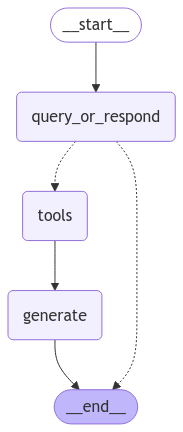

In [258]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [253]:
def ask_chain(graph, input_message):
    """
    Executes the conversation chain for a user input and streams the results.

    Args:
        graph (StateGraph): The compiled state graph representing the conversation flow.
        input_message (str): The user's message to process.

    Yields:
        None: Prints each step's response from the assistant in real-time.
    """
    for step in graph.stream(
            {"messages": [{"role": "user", "content": input_message}]},
            stream_mode="values",
            config=config,  # passing the context
        ):
        step["messages"][-1].pretty_print()

In [272]:
# input_message = "Does it increase in its value according to the news?"
input_message = "What has Apple become known for?"
# input_message = "What represented 56% of fiscal first-quarter sales of Apple?"

ask_chain(graph, input_message)

================================ Human Message =================================

What has Apple become known for?
...retrieving using query 'What has Apple become known for?'...
================================== Ai Message ==================================

Answer: reality. The firm designs its own software and semiconductors while working with subcontractors like Foxconn and TSMC to build its products and chips. Slightly less than half of Apple s sales come directly through its flagship stores, with a majority of sales coming indirectly through partnerships and distribution.

reality. The firm designs its own software and semiconductors while working with subcontractors like Foxconn and TSMC to build its products and chips. Slightly less than half of Apple s sales come directly through its flagship stores, with a majority of sales coming indirectly through partnerships and distribution.
Sources with publication dates: https://www.benzinga.com/insights/options/25/02/43671869/decodin

In [273]:
input_message = "Does it increase in its value according to the news?"

ask_chain(graph, input_message)

================================ Human Message =================================

Does it increase in its value according to the news?
================================== Ai Message ==================================
Tool Calls:
  retrieve (5adb1d70-79df-4c96-aa00-7b260db7ecb0)
 Call ID: 5adb1d70-79df-4c96-aa00-7b260db7ecb0
  Args:
    query: Apple stock performance based on news
...retrieving using query 'Apple stock performance based on news'...
================================= Tool Message =================================
Name: retrieve

{"answer": "our objective is to provide valuable insights for investors and offer a deeper understanding of company s performance in the industry.\n\nZacks Equity ResearchFebruary 13, 2025\nPRSCX Quick QuotePRSCXFSELX Quick QuoteFSELXKTCAX Quick QuoteKTCAX\nBetter trading startshere.\nYou follow Mutual Fund Commentary  edit\nYou follow Zacks Equity Research  edit\nZacks Equity Research\nMutual Fund Commentary", "sources": ["https://www.benzinga.com

In [274]:
input_message = "How is TikTok connected to Apple?"

ask_chain(graph, input_message)

================================ Human Message =================================

How is TikTok connected to Apple?
================================== Ai Message ==================================

 The connection between TikTok and Apple primarily revolves around the platform's availability on iOS devices, as well as the partnership between the two companies for app development.

TikTok is a popular short-form video sharing social media app that allows users to create and share videos with music and effects. It gained significant popularity worldwide, especially among younger audiences.

Apple plays a role in the distribution of TikTok on its iOS devices through the App Store. Users can download and install TikTok from the App Store onto their iPhones or iPads. In addition to this, Apple and TikTok have partnered for app development, allowing TikTok creators to use Apple's ARKit technology to enhance their videos with augmented reality effects.

Sources with publication dates:
- https

In [275]:
input_message = "What represented 56% of fiscal first-quarter sales of Apple?"

ask_chain(graph, input_message)

================================ Human Message =================================

What represented 56% of fiscal first-quarter sales of Apple?
================================== Ai Message ==================================
Tool Calls:
  retrieve (3a6b91bf-22df-4441-8b41-21f858be8308)
 Call ID: 3a6b91bf-22df-4441-8b41-21f858be8308
  Args:
    query: Apple fiscal first-quarter sales breakdown
...retrieving using query 'Apple fiscal first-quarter sales breakdown'...
================================= Tool Message =================================
Name: retrieve

{"answer": "Zacks Equity ResearchFebruary 13, 2025\nAAPL Quick QuoteAAPLMSFT Quick QuoteMSFTVTV Quick QuoteVTVFNDX Quick QuoteFNDXSCHD Quick QuoteSCHD\nBetter trading startshere.\nYou follow Style Box ETF  edit\nYou follow Zacks Equity Research  edit\nZacks Equity Research\nStyle Box ETF\n\nZacks Equity ResearchFebruary 13, 2025\nAAPL Quick QuoteAAPLMSFT Quick QuoteMSFTNVDA Quick QuoteNVDAQQQ Quick QuoteQQQVUG Quick QuoteVUGVONG Q

In [276]:
state = graph.get_state(config).values

for message in state["messages"]:
    print(message)
    message.pretty_print()

content='What has Apple become known for?' additional_kwargs={} response_metadata={} id='7c5364c9-559d-42f7-8164-fbe5c5f88ceb'
================================ Human Message =================================

What has Apple become known for?
content='Answer: reality. The firm designs its own software and semiconductors while working with subcontractors like Foxconn and TSMC to build its products and chips. Slightly less than half of Apple s sales come directly through its flagship stores, with a majority of sales coming indirectly through partnerships and distribution.\n\nreality. The firm designs its own software and semiconductors while working with subcontractors like Foxconn and TSMC to build its products and chips. Slightly less than half of Apple s sales come directly through its flagship stores, with a majority of sales coming indirectly through partnerships and distribution.\nSources with publication dates: https://www.benzinga.com/insights/options/25/02/43671869/decoding-apple

## Agent Style

In [80]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

In [81]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What has Apple become known for?\n\n"
    "Once you get the answer, look up what represented 56% of fiscal first-quarter sales of Apple."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What has Apple become known for?

Once you get the answer, look up what represented 56% of fiscal first-quarter sales of Apple.
================================== Ai Message ==================================
Tool Calls:
  retrieve (ccff7516-e7ab-4d86-9037-801b74e193c5)
 Call ID: ccff7516-e7ab-4d86-9037-801b74e193c5
  Args:
    query: What is Apple most known for?
  retrieve (3dc9b984-0ed8-4503-b8ac-e1d4ac366e72)
 Call ID: 3dc9b984-0ed8-4503-b8ac-e1d4ac366e72
  Args:
    query: What represented 56 of fiscal first-quarter sales of Apple?
Retrieving using query:  What is Apple most known for?
Retrieving using query:  What represented 56 of fiscal first-quarter sales of Apple?
================================= Tool Message =================================
Name: retrieve

{"answer": "Apple\nApple has become known for products like its namesake watch, Mac, iPad, and iPhone.  However, it's the last item that a